In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
from statsforecast.models import AutoARIMA
from utilsforecast.losses import mae, mape, rmse  

In [138]:
df = pd.read_csv(r"C:\Users\Nav\Documents\BaggageRevenueModel\BaggageRevenueModel\data\combined_bag_revenue.csv")
df.head()

,Airline,2015-Q1,2015-Q2,2015-Q3,2015-Q4,2016-Q1,2016-Q2,2016-Q3,2016-Q4,2017-Q1,...,2022-Q3,2022-Q4,2023-Q1,2023-Q2,2023-Q3,2023-Q4,2024-Q1,2024-Q2,2024-Q3,2024-Q4
0,Alaska,23686.0,30215.0,34127.0,24787.0,30484.0,35022.0,39297.0,30811.0,30602.0,...,92981.0,80917.0,74482.0,97943.0,101337.0,84549.0,83934.0,106033.0,118372.0,98236.0
1,Allegiant,40444.0,42463.0,39934.0,38523.0,43759.0,45934.0,45168.0,42468.0,46556.0,...,83634.0,80586.0,88685.0,96696.0,86787.0,85386.0,90754.0,101292.0,90031.0,89385.0
2,American,151758.0,165660.0,292089.0,267293.0,262464.0,288836.0,288124.0,278048.0,272805.0,...,351356.0,348944.0,325296.0,352279.0,342047.0,337299.0,334743.0,394435.0,389782.0,382369.0
3,Delta,198119.0,226294.0,236890.0,213799.0,197690.0,232461.0,228971.0,213297.0,203507.0,...,252159.0,234831.0,226255.0,253222.0,259462.0,246286.0,239012.0,289749.0,259227.0,272113.0
4,Frontier,42011.0,49565.0,56582.0,71886.0,70755.0,71578.0,84962.0,79497.0,80224.0,...,201770.0,222968.0,221438.0,231463.0,211176.0,215842.0,203624.0,233695.0,212662.0,211643.0


In [139]:
# Reshape data for statsforecast

df_long = df.melt(id_vars=['Airline'], var_name='Quarter', value_name="Baggage Revenue")
df_long['Quarter'] = pd.PeriodIndex(df_long['Quarter'], freq='Q').to_timestamp(how="end")
df_long = df_long.rename(columns={"Airline": "unique_id", "Baggage Revenue": "y"})

# Final columns should be ['unique_id', 'ds', 'y']
df_long = df_long[['unique_id', 'Quarter', 'y']].rename(columns={"Quarter": "ds"})
df_long

,unique_id,ds,y
0,Alaska,2015-03-31 23:59:59.999999999,23686.0
1,Allegiant,2015-03-31 23:59:59.999999999,40444.0
2,American,2015-03-31 23:59:59.999999999,151758.0
3,Delta,2015-03-31 23:59:59.999999999,198119.0
4,Frontier,2015-03-31 23:59:59.999999999,42011.0
...,...,...,...
435,JetBlue,2024-12-31 23:59:59.999999999,143084.0
436,Southwest,2024-12-31 23:59:59.999999999,20956.0
437,Spirit,2024-12-31 23:59:59.999999999,123925.0
438,Sun Country,2024-12-31 23:59:59.999999999,25469.0


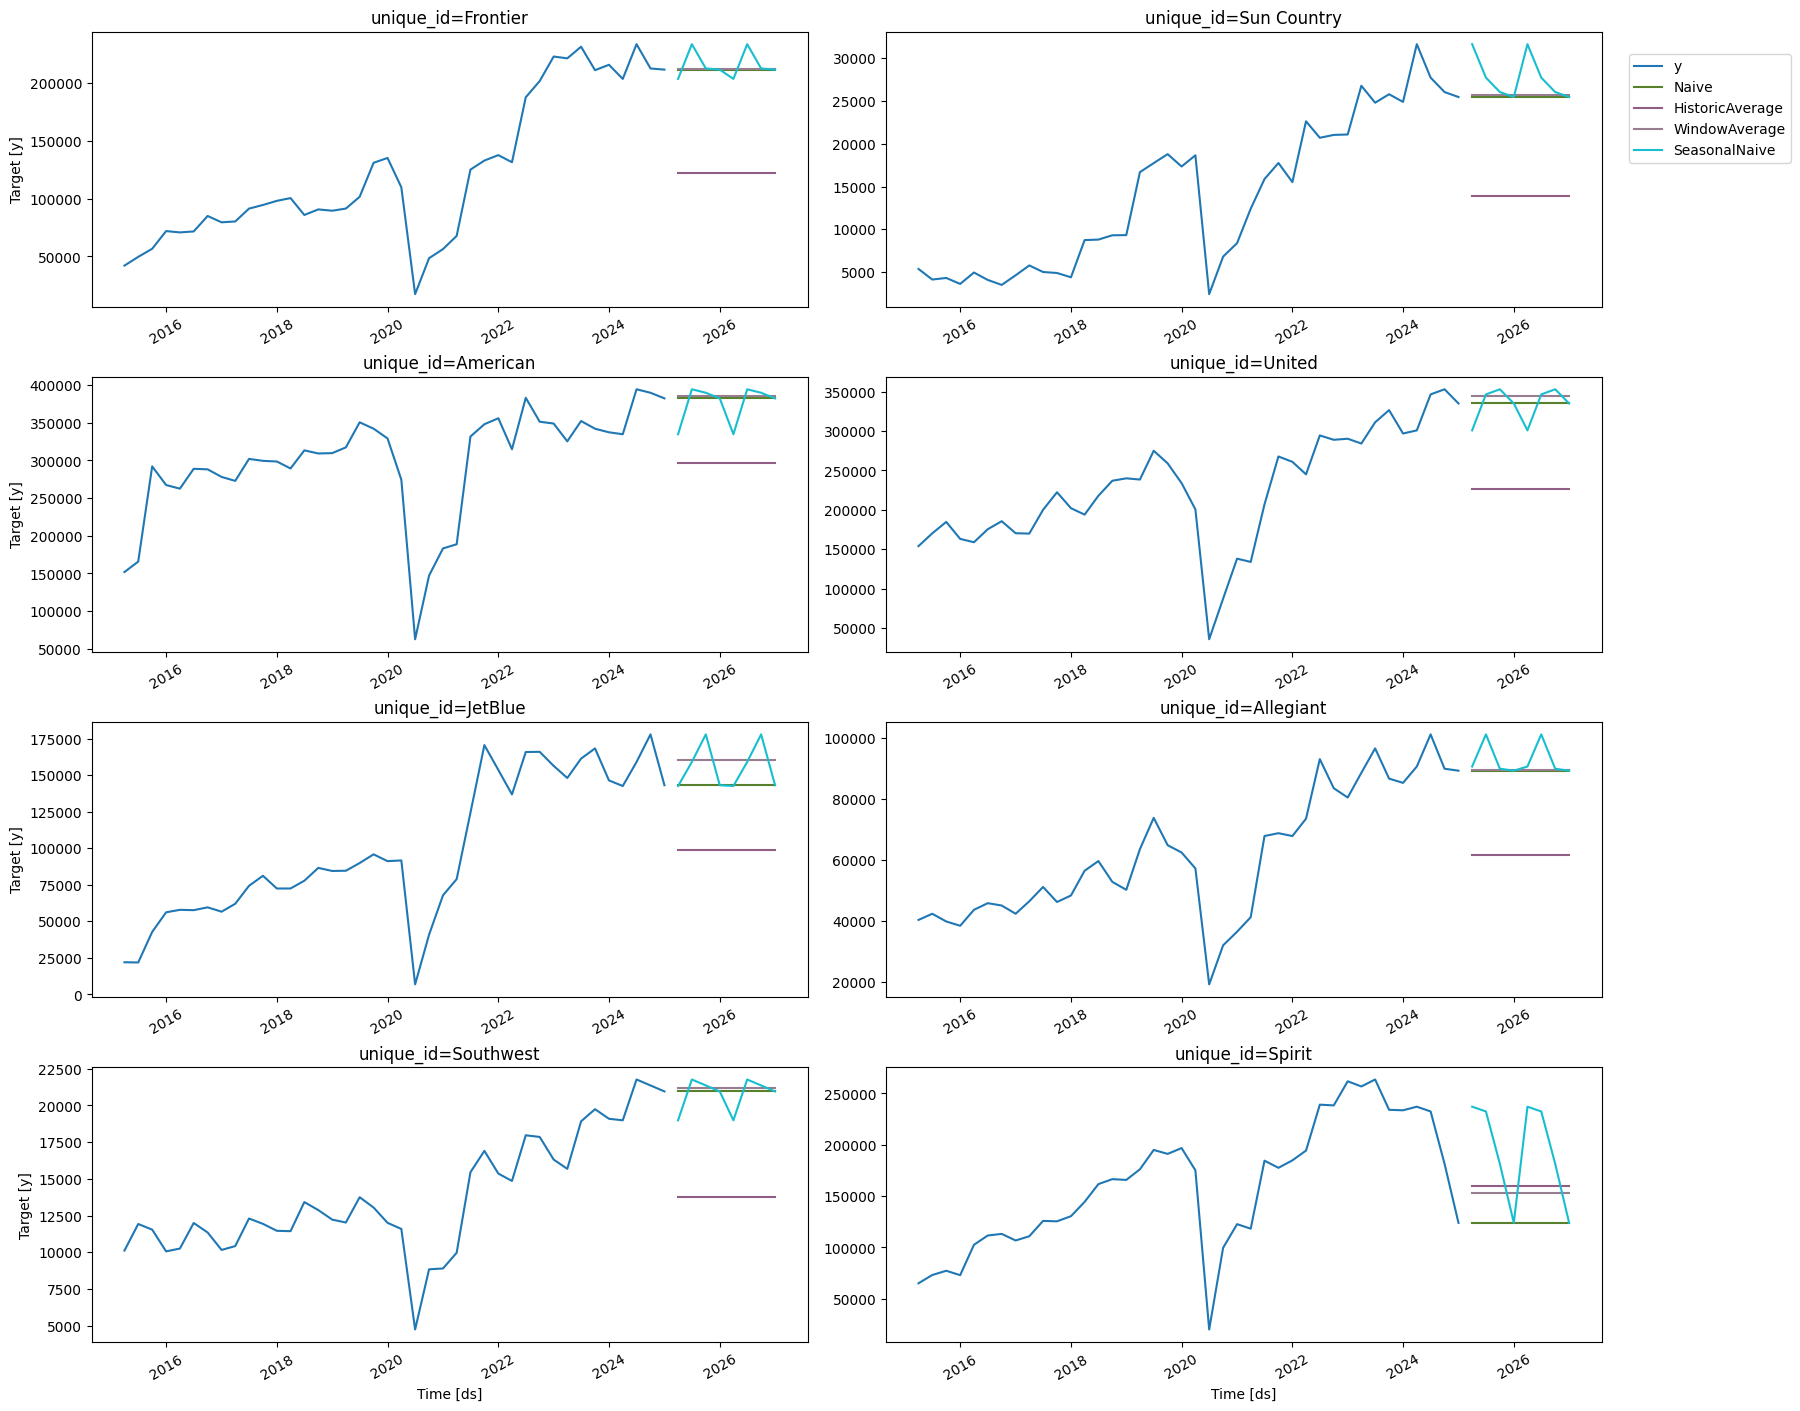

In [140]:
# Baseline models
horizon = 8 # forecasting a year ahead

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=2),
    SeasonalNaive(season_length=4)
]

sf = StatsForecast(models=models, freq='QE')
sf.fit(df=df_long)
preds = sf.predict(h=horizon)
preds.head()
plot_series(df=df_long, forecasts_df=preds)

In [141]:
# Evaluation of Baseline Models

test = df_long.groupby('unique_id').tail(horizon)
train = df_long.drop(test.index).reset_index(drop=True)

In [142]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['unique_id', 'ds'])

In [143]:
evaluation = evaluate( df=eval_df, metrics=[mae, mape, rmse] )
evaluation

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,Alaska,mae,16302.500000,41264.156250,13132.250000,13963.500000
1,Allegiant,mae,10541.000000,36800.500000,9017.000000,8364.000000
2,American,mae,22435.000000,75493.500000,22435.000000,20674.250000
3,Delta,mae,22978.750000,44036.750000,17601.500000,14049.000000
4,Frontier,mae,10080.625000,119075.218750,7989.875000,36317.125000
5,Hawaiian,mae,1981.000000,2376.109375,2430.125000,2170.000000
6,JetBlue,mae,10796.250000,71248.125000,11331.000000,8228.750000
7,Southwest,mae,3408.375000,7283.406250,2830.875000,2815.625000
8,Spirit,mae,41857.250000,80832.226562,34736.250000,45416.000000
9,Sun Country,mae,5561.000000,15879.468750,5585.500000,5283.250000


In [144]:
# ARIMA and SARIMA Models

unique_ids = df_long["unique_id"].unique().tolist()
small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]


models = [
    AutoARIMA(season_length=1, max_P=0, max_Q=0, alias="ARIMA"),
    AutoARIMA(season_length=4, max_P=4, max_Q=4, alias="SARIMA"),
]

sf = StatsForecast(models=models, freq='QE')
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(test, arima_preds, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate( df=arima_eval_df, metrics=[mae] )
arima_eval

,unique_id,metric,ARIMA,SARIMA
0,Alaska,mae,16302.500000,16302.500000
1,Allegiant,mae,10541.000000,10541.000000
2,American,mae,60433.837956,85568.927084
3,Delta,mae,42416.662620,50599.964311
4,Frontier,mae,10080.625000,10080.625000
5,Hawaiian,mae,2565.095847,3005.125084
6,JetBlue,mae,10796.250000,10796.250000
7,Southwest,mae,3408.375000,3408.375000
8,Spirit,mae,41857.250000,41857.250000
9,Sun Country,mae,5561.000000,5561.000000


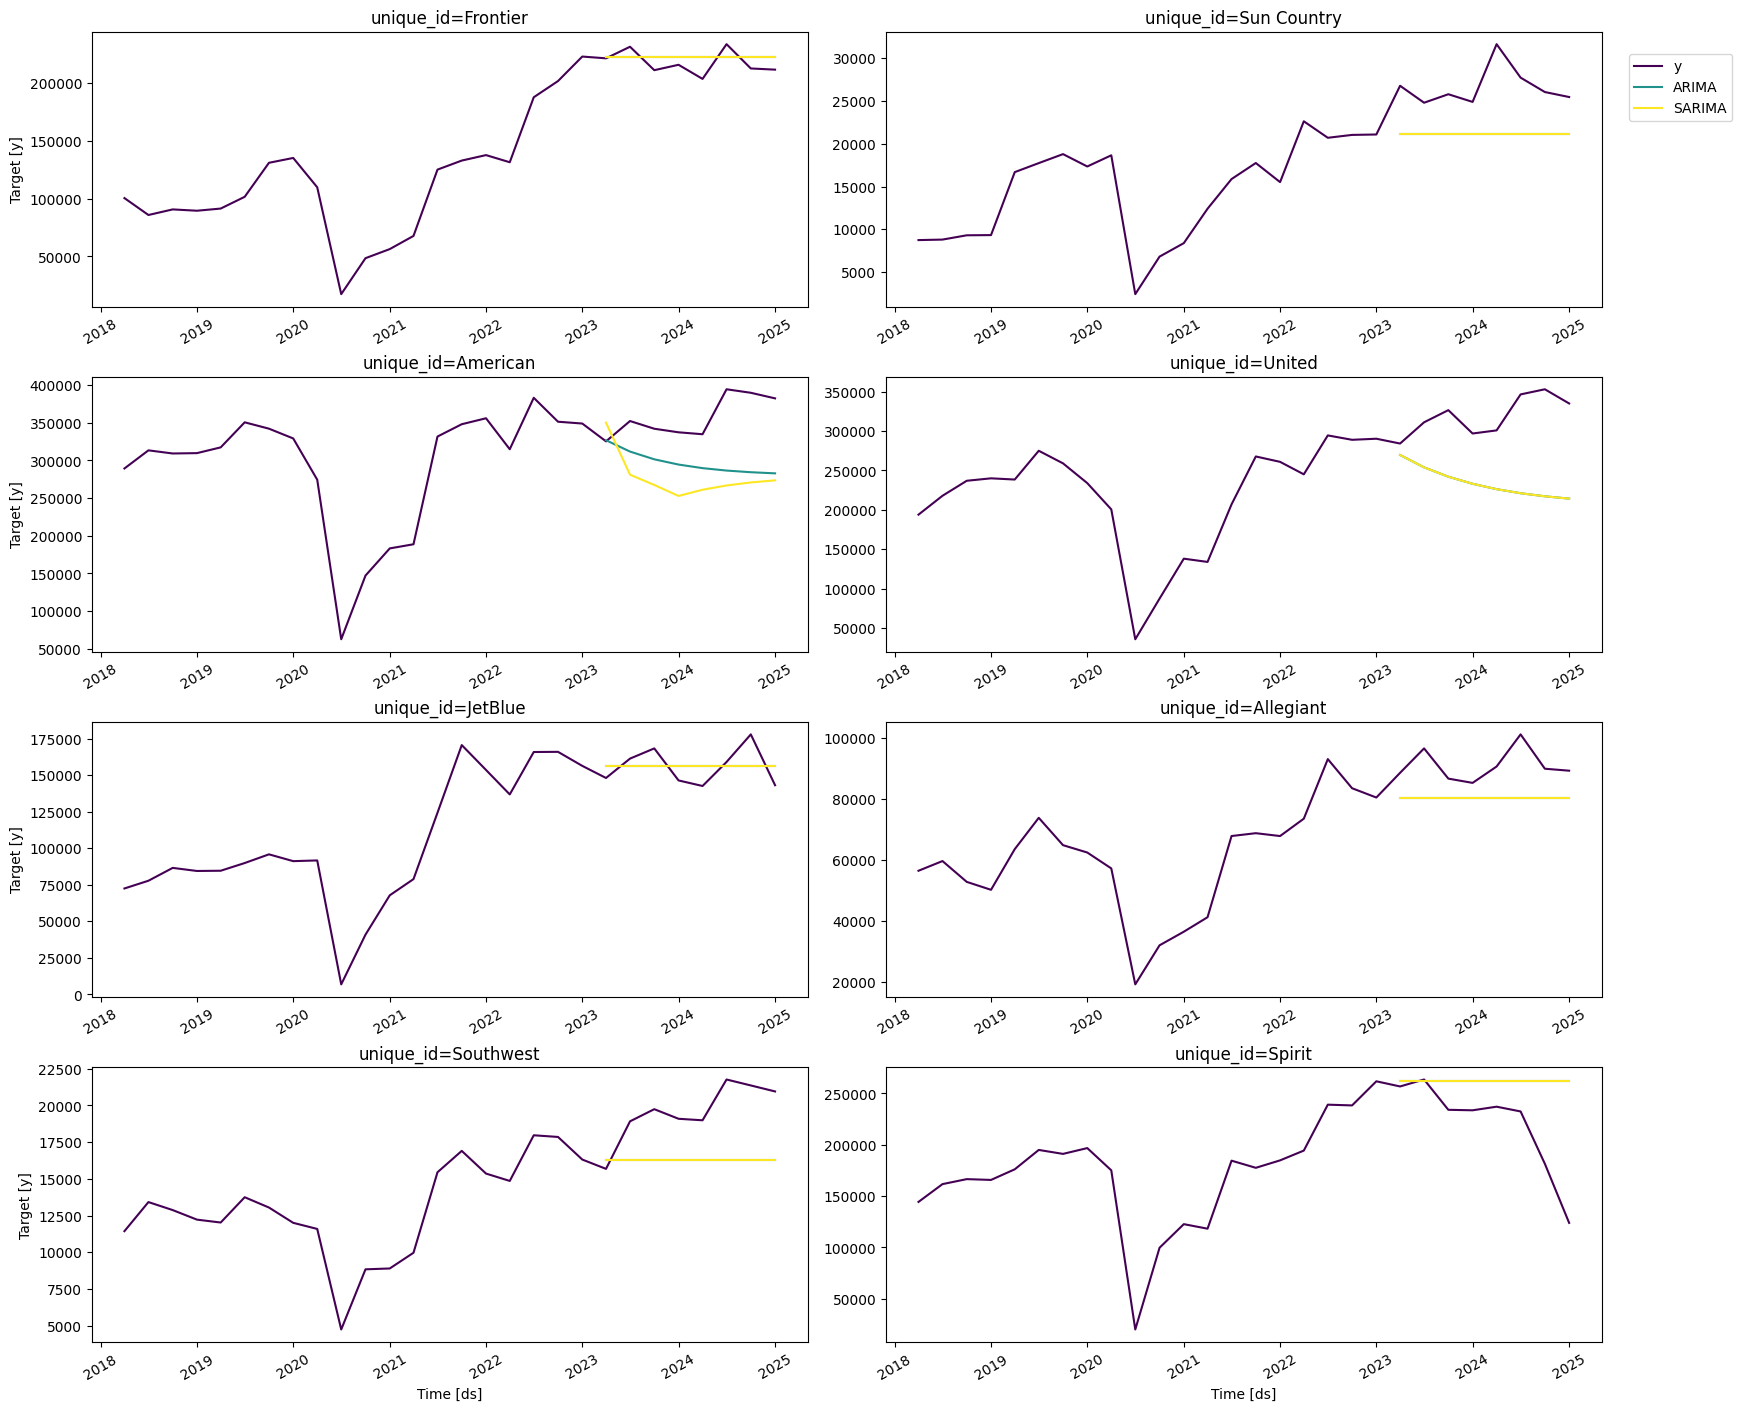

In [145]:
# plotting

ids_to_show = df_long['unique_id'].unique().tolist()
arima_plot = arima_preds[["unique_id","ds","ARIMA","SARIMA"]]

# Make the plot
plot_series(
    df=df_long,                          
    forecasts_df=arima_plot,       
    ids=ids_to_show,          
    max_insample_length=28,    
    palette="viridis"
)

In [150]:
## Cross-Validation
small_df = df_long[df_long["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=4),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=4, alias="SARIMA")
]

sf = StatsForecast(models=models,  freq="QE")
cv_df = sf.cross_validation(
    h=horizon,
    df=df_long,
    n_windows=4,
    step_size=horizon,
    refit=True
)

cv_df

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,Alaska,2017-03-31 23:59:59.999999999,2016-12-31 23:59:59.999999999,30602.0,30484.0,31053.625000,31053.625000
1,Alaska,2017-06-30 23:59:59.999999999,2016-12-31 23:59:59.999999999,38232.0,35022.0,31053.625000,31053.625000
2,Alaska,2017-09-30 23:59:59.999999999,2016-12-31 23:59:59.999999999,42114.0,39297.0,31053.625000,31053.625000
3,Alaska,2017-12-31 23:59:59.999999999,2016-12-31 23:59:59.999999999,36295.0,30811.0,31053.625000,31053.625000
4,Alaska,2018-03-31 23:59:59.999999999,2016-12-31 23:59:59.999999999,48800.0,30484.0,31053.625000,31053.625000
...,...,...,...,...,...,...,...
347,United,2023-12-31 23:59:59.999999999,2022-12-31 23:59:59.999999999,296843.0,290224.0,233074.954938,233074.954938
348,United,2024-03-31 23:59:59.999999999,2022-12-31 23:59:59.999999999,300800.0,245070.0,226270.014747,226270.014747
349,United,2024-06-30 23:59:59.999999999,2022-12-31 23:59:59.999999999,346431.0,294420.0,221114.723372,221114.723372
350,United,2024-09-30 23:59:59.999999999,2022-12-31 23:59:59.999999999,352933.0,288856.0,217209.174107,217209.174107


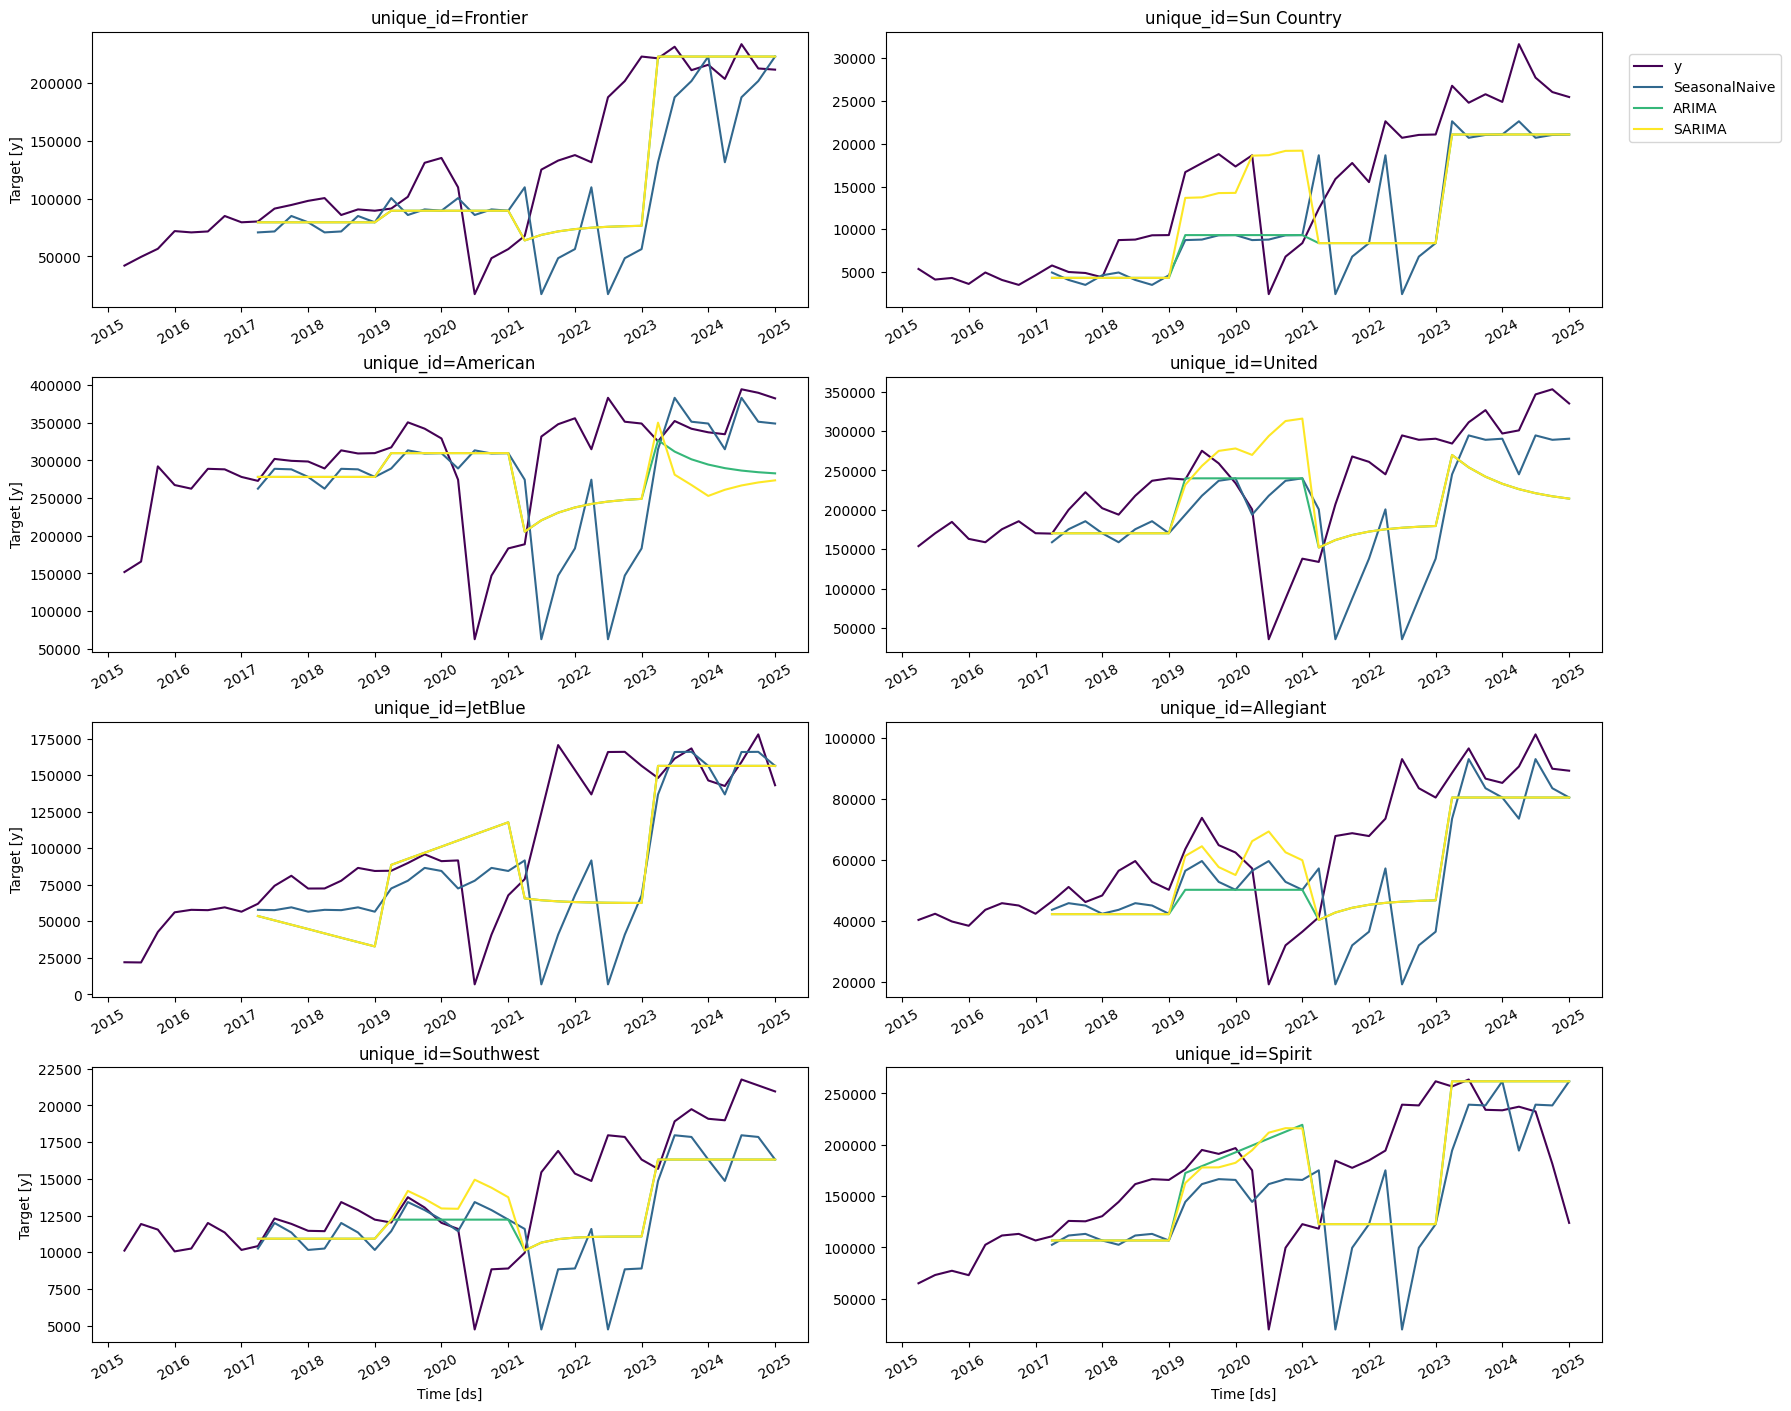

In [154]:
ids_to_show = df_long['unique_id'].unique().tolist()
arima_plot = arima_preds[["unique_id","ds","ARIMA","SARIMA"]]

# Make the plot
plot_series(
    df=small_df,                          
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),      
    ids=ids_to_show,          
    max_insample_length=40,    
    palette="viridis"
)